# Modeling the DESI spectrograph resolution with Resolution Matrices

Arguably the most complex aspect of the DESI spectral data is the concept of the "Resolution Matrix"
to model the spectrograph wavelength resolution. Rather than approximate this as a full width half max (FWHM)
or Gaussian sigma, as is traditionally done, DESI represents this instrument resolution (line spread function)
as a matrix that is used to convolve a perfect resolution model down to the DESI spectrograph resolution.
This is calculated per-fiber per-wavelength per-exposure, following the "spectroperfectionism" extraction method of
[Bolton & Schlegel 2012](https://ui.adsabs.harvard.edu/abs/2010PASP..122..248B/abstract),
described in more detail in [Guy+ 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..144G/abstract)
sections 4.5 and appendix D.

This tutorial will show how to use the Resolution Matrix, describe the underlying format if you need to use
it without any DESI code packages, and document some gotchas.

See [01_getting_started/00_Setup.md](../01_getting_started/00_Setup.md) for how to install the DESI code
and download example data.

<!--
Conceptually, when the resolution matrix "R" is matrix-multiplied by an perfect resolution model spectrum, it produces
the as-observed-by-the-DESI-instrument resolution model, to be compared to the data.

On disk, the resolution matrix is stored as the (off)diagonals of a band-diagonal matrix intended to
be used with the [scipy.sparse.dia_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dia_matrix.html) class.

First, an example without using DESI-specific code to construct the resolution matrix:
-->

## Imports

In [1]:
import os
import numpy as np
import scipy.sparse
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt

import desispec.io
import redrock.templates
from desitarget.targetmask import desi_mask

## Find DESI data location under $DESI_ROOT

In [2]:
# os.environ['DESI_ROOT'] = /path/to/where/you/have/desidata
# see 01_getting_started/00_Setup.md

if 'DESI_ROOT' not in os.environ:
    errmsg = "Please set $DESI_ROOT to location of DESI data prior to running this tutorial"
    raise(RuntimeError(errmsg))

assert os.path.isdir(os.environ['DESI_ROOT'])
print(f"Using $DESI_ROOT={os.environ['DESI_ROOT']}")

Using $DESI_ROOT=/Users/sbailey/desi/tiny_dr1/


## Modeling an ELG Spectrum

We'll start by looking at how the Resolution Matrix applies to the Redrock model of the [OII] 3727,3729
emission line doublet of an ELG spectrum.
The concepts here are more general than just Redrock; we're just using Redrock as a specific model to
study the effect of the instrument resolution and how to use the Resolution Matrix.

**NOTE**: In this section we'll use `desispec` and `redrock` code to simplify reading the spectra and generating the Redrock model.
See [RedrockOutputs.ipynb](RedrockOutputs.ipynb) for examples of how to do this without using any DESI code.
After this section we'll show how to construct the Resolution Matrix for a spectrum without using any DESI code,
in case you need to do an analysis without including DESI-specific code dependencies.

### Read the coadded spectra and matching Redrock redshift catalog

In [3]:
#- hardcode values for data included in the tiny_dr1 subset for tutorials
specprod = 'iron'
healpix = 23040
survey = 'main'
program = 'dark'

coaddfile = desispec.io.findfile('coadd', healpix=healpix, survey=survey, faprogram=program, specprod=specprod)
redrockfile = desispec.io.findfile('redrock', healpix=healpix, survey=survey, faprogram=program, specprod=specprod)
print(f'{coaddfile=}')
print(f'{redrockfile=}')

spectra = desispec.io.read_spectra(coaddfile)
zcat = Table.read(redrockfile, 'REDSHIFTS')

coaddfile='/Users/sbailey/desi/tiny_dr1/spectro/redux/iron/healpix/main/dark/230/23040/coadd-main-dark-23040.fits'
redrockfile='/Users/sbailey/desi/tiny_dr1/spectro/redux/iron/healpix/main/dark/230/23040/redrock-main-dark-23040.fits'
INFO:spectra.py:391:read_spectra: iotime 0.268 sec to read coadd-main-dark-23040.fits at 2025-03-17T15:24:50.588185


### Trim to ELG targets with [OII] on the r-camera

In [4]:
#- confirm that spectra are row-aligned with zcat
assert np.all(spectra.fibermap['TARGETID'] == zcat['TARGETID'])

#- ELG target
keep = (spectra.fibermap['DESI_TARGET'] & desi_mask.ELG) != 0     # Note: desi_mask.ELG==2

#- Confident spectral identification
keep &= (zcat['SPECTYPE']=='GALAXY') & (zcat['ZWARN']==0) & (zcat['DELTACHI2']>100)

#- [OII] 3727,3729 on the r-camera
camera = 'r'
zmin = (spectra.wave[camera][0]+50)/3728 - 1
zmax = (spectra.wave[camera][-1]-50)/3728 - 1
keep &= (zmin < zcat['Z']) & (zcat['Z'] < zmax)
np.sum(keep)

155

### Plot one of the targets

We'll do this at several levels of zoom around the [OII] doublet,
since the full spectrum basically just looks like noise.
If we zoom in around the expected [OII] location at the identified
redshift, it is plausibly a nice doublet.

In [5]:
i = np.where(keep)[0][1]
z = zcat['Z'][i]
coeff = zcat['COEFF'][i]

#- range to zoom in around [OII] 3727,3729 doublet
dw = 30
wmin, wmax = (3728*(1+z)-dw, 3728*(1+z)+dw)

Text(0, 0.5, 'Flux')

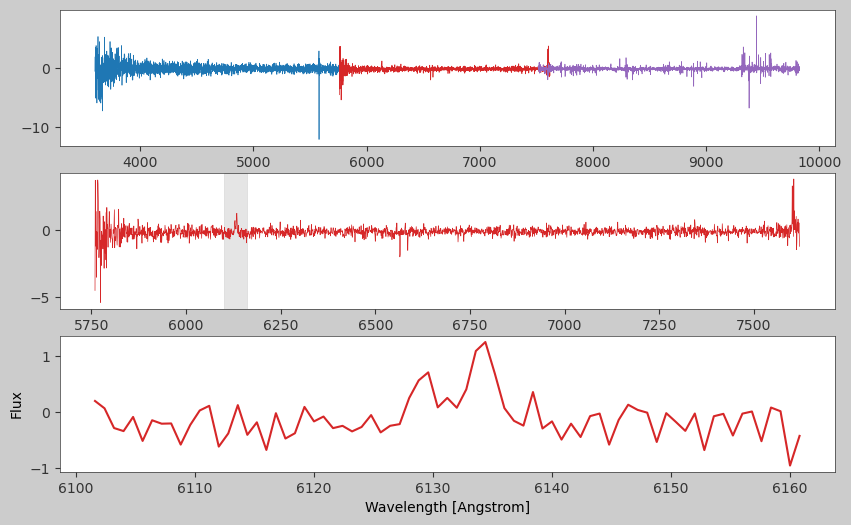

In [6]:
plt.figure(figsize=(10,6))

plt.subplot(311)
for camera, color in [('b','C0'), ('r','C3'), ('z', 'C4')]:
    ok = spectra.ivar[camera][i]>0
    wave = spectra.wave[camera][ok]
    flux = spectra.flux[camera][i][ok]
    plt.plot(wave, flux, '-', color=color, lw=0.5)

plt.subplot(312)
camera = 'r'
color = 'C3'
ok = spectra.ivar[camera][i]>0
wave = spectra.wave[camera][ok]
flux = spectra.flux[camera][i][ok]
plt.plot(wave, flux, '-', color=color, lw=0.5)
plt.axvspan(wmin, wmax, color='k', alpha=0.1)

plt.subplot(313)
ii = (wmin < wave) & (wave < wmax)
plt.plot(wave[ii], flux[ii], '-', color=color)

plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux')

### Generate the Redrock model for this object

In [7]:
#- Load the Redrock templates used for this specprod
template_dir = redrock.templates.get_template_dir()
templates = redrock.templates.load_templates(f'{template_dir}/templates-{specprod}.txt', asdict=True)

DEBUG: Reading templates from /Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/templates-iron.txt
Reading templates from ['/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-GALAXY-None-v2.6.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-QSO-LOZ-v1.0.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-QSO-HIZ-v1.0.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-STAR-A-v0.1.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-STAR-B-v0.1.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templates/rrtemplate-STAR-CV-v0.1.fits', '/Users/sbailey/miniforge3/envs/desitest/lib/python3.12/site-packages/redrock/data/templa

In [8]:
#- Pick just the galaxy template
template = templates[('GALAXY', '')]

In [9]:
#- Generate the Redrock model
camera = 'r'
wave = spectra.wave[camera]
flux = spectra.flux[camera][i]
ivar = spectra.ivar[camera][i]
err = np.sqrt(1/ivar)

model = template.eval(coeff, wave, z)

Text(0, 0.5, 'Flux')

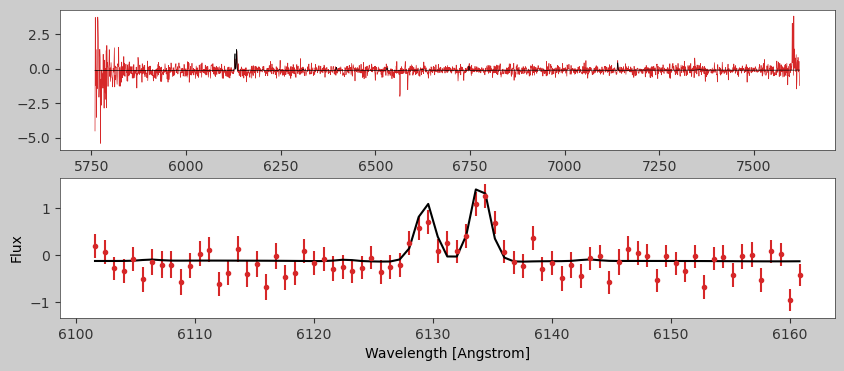

In [10]:
#- Plot the model on top of the data
plt.figure(figsize=(10,4))
plt.subplot(211)
plt.plot(wave, flux, '-', color='C3', lw=0.5)
plt.plot(wave, model, '-', color='k', lw=0.5)

plt.subplot(212)
ii = (wmin < wave) & (wave < wmax)
plt.errorbar(wave[ii], flux[ii], err[ii], fmt='.', color='C3')
plt.plot(wave[ii], model[ii], '-', color='k')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux')

It's not super-obvious, but that model is just a little bit narrower than the data.
This is because the coefficients * templates that we calculated is the model
*before* convolving with the instrument resolution
for that particular spectrum.  This allows Redrock to use the same set of perfect-resolution templates to model
different spectra at different instrument resolutions, e.g. to due the variation of resolution with wavelength
and between different fibers observing the spectra.  While fitting the data, Redrock convolves the
model with the per-spectrum per-wavelength resolution *before* comparing with the data to form the $\chi^2$.

**NOTE**: This concept is not specific to Redrock — if you are fitting a model to the data, ideally you should
fit the *resolution convolved model* to the data.

### OK, that's great, but how do I actually do that?

If you are using `desispec.io.read_spectra` to read the coadd files, the Resolution Matrix that you need for each spectrum for each
camera is pre-generated as a sparse band-diagonal matrix in `spectra.R[camera][index]`.  Let's look at that for the target `i` that we were
plotting before.

In [11]:
R = spectra.R[camera][i]
print(f'R is a {type(R)}')
print('This is a subclass of scipy.sparse.dia_matrix:', isinstance(R, scipy.sparse.dia_matrix))
print(f'{R.shape=} which NxN matches {len(wave)=}')
print(f'It has {R.nnz} = {100*R.nnz/len(wave)**2:.2f}% non-zero elements')

R is a <class 'desispec.resolution.Resolution'>
This is a subclass of scipy.sparse.dia_matrix: True
R.shape=(2326, 2326) which NxN matches len(wave)=2326
It has 25556 = 0.47% non-zero elements


Storing it as a band-diagonal matrix uses much less memory and is faster to multiply by a model than if we had stored it as a full dense matrix of mostly zeros.

Let's zoom in on a small section of the Resolution matrix R and plot it (which does require converting it to a dense matrix, but only for plotting).

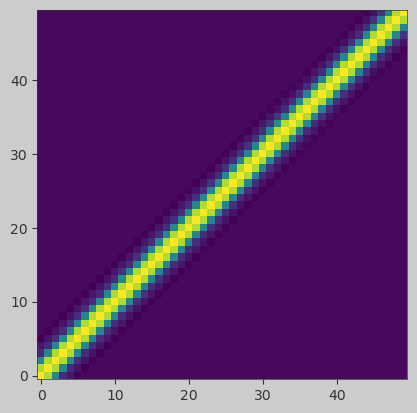

In [12]:
Rx = R.toarray()[100:150, 100:150]
plt.imshow(np.log(Rx+1e-3))

That is plausibly a matrix that could be multiplied by a vector to convolve it to a lower resolution, i.e. the instrument resolution.
Let's take a slice through that matrix and plot on a log scale:

Text(0.5, 1.0, 'Column 10 of the resolution matrix')

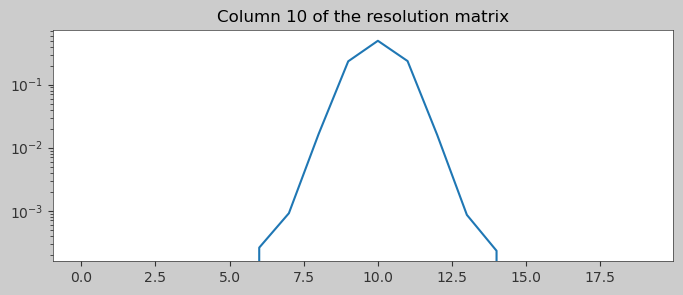

In [13]:
plt.figure(figsize=(8,3))
plt.plot(Rx[0:20, 10])
plt.semilogy()
plt.title('Column 10 of the resolution matrix')

If the resolution were perfectly Gaussian, that would look like an inverted parabola.
We can see that in the wings, there are non-Gaussian tails that would not be well modeled by
either a Gaussian or a FWHM parameterization.  It is subtle, but important for detailed modeling.

Let's now use that to convolve the model with the instrument resolution (R) and see if that improves the $\chi^2$.

Text(0.05, 0.7, '$\\chi^2$/ndof=72.9/65')

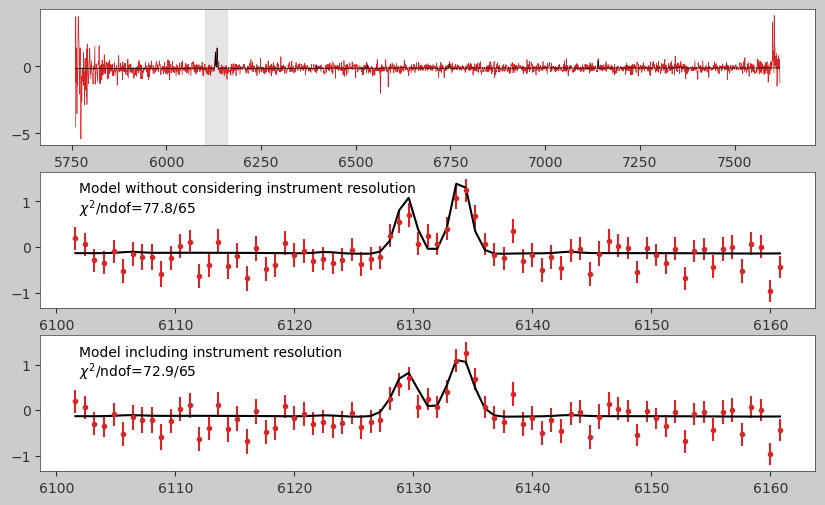

In [14]:
#- refresh the variables, in case earlier exploration modified them
camera = 'r'
wave = spectra.wave[camera]
flux = spectra.flux[camera][i]
ivar = spectra.ivar[camera][i]
err = np.sqrt(1/ivar)
R = spectra.R[camera][i]
model = template.eval(coeff, wave, z)
ii = (wmin < wave) & (wave < wmax)
ndof = np.sum(ii) - template.nbasis

plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(wave, flux, color='C3', lw=0.5)
plt.plot(wave, model, 'k-', lw=0.5)
plt.axvspan(wmin, wmax, color='k', alpha=0.1)

plt.subplot(312)
ii = (wmin<wave) & (wave<wmax)
plt.errorbar(wave[ii], flux[ii], err[ii], fmt='.', color='C3')
plt.plot(wave[ii], model[ii], 'k-')
chi2 = np.sum( (flux[ii]-model[ii])**2 * ivar[ii] )
plt.text(0.05, 0.85, 'Model without considering instrument resolution', transform=plt.gca().transAxes)
plt.text(0.05, 0.70, r'$\chi^2$/ndof'+f'={chi2:.1f}/{ndof}', transform=plt.gca().transAxes)

plt.subplot(313)
ii = (wmin<wave) & (wave<wmax)
plt.errorbar(wave[ii], flux[ii], err[ii], fmt='.', color='C3')
plt.plot(wave[ii], R.dot(model)[ii], 'k-')
chi2 = np.sum( (flux[ii]-R.dot(model)[ii])**2 * ivar[ii] )
plt.text(0.05, 0.85, 'Model including instrument resolution', transform=plt.gca().transAxes)
plt.text(0.05, 0.70, r'$\chi^2$/ndof'+f'={chi2:.1f}/{ndof}', transform=plt.gca().transAxes)

# plt.axhline(0, color='0.9')

It still isn't a perfect fit, but the $\chi^2$ is distinctly improved by considering the instrument resolution.

## Underlying format

We'll now take a step back and explore the underlying format of the Resolution Matrix on disk, and how
one could be constructed without using DESI-specific code.

On disk, the resolution matrix is stored in the `B/R/Z_RESOLUTION` HDUs as the (off)diagonals of a band-diagonal matrix intended to
be used with the [scipy.sparse.dia_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dia_matrix.html) class.

In [15]:
with fitsio.FITS(coaddfile) as fp:
    wave = fp['R_WAVELENGTH'].read()
    flux = fp['R_FLUX'].read()
    resolution_diags = fp['R_RESOLUTION'].read()

In [16]:
print(f'{wave.shape=}')
print(f'{flux.shape=}')
print(f'{resolution_diags.shape=}')
num_wavelengths = wave.shape[0]
num_spectra = flux.shape[0]
num_diagonals = resolution_diags.shape[1]
print(f'There are {num_spectra} spectra with {num_wavelengths} wavelengths, and the resolution data has {num_diagonals} diagonals')

wave.shape=(2326,)
flux.shape=(1323, 2326)
resolution_diags.shape=(1323, 11, 2326)
There are 1323 spectra with 2326 wavelengths, and the resolution data has 11 diagonals


The `resolution_diags` data is a 3D matrix with dimensions `[num_spectra, num_diagonals, num_wavelengths`,
i.e. `resoolution_diags[i]` contains the diagonals for the resolution matrix for specrum `i`.  This is
designed to be used with the `scipy.sparse.dia_matrix` class with the constructor of the form
`dia_matrix((data, offsets), shape=(M, N))` where `data[k,:]` stores the diagonal entries for
diagonal `offsets[k]` to create a `shape=(num_wavelengths, num_wavelengths)` array.

In [17]:
scipy.sparse.dia_matrix?

Init signature:
scipy.sparse.dia_matrix(
    arg1,
    shape=None,
    dtype=None,
    copy=False,
    *,
    maxprint=None,
)
Docstring:     
Sparse matrix with DIAgonal storage.

This can be instantiated in several ways:
    dia_matrix(D)
        where D is a 2-D ndarray

    dia_matrix(S)
        with another sparse array or matrix S (equivalent to S.todia())

    dia_matrix((M, N), [dtype])
        to construct an empty matrix with shape (M, N),
        dtype is optional, defaulting to dtype='d'.

    dia_matrix((data, offsets), shape=(M, N))
        where the ``data[k,:]`` stores the diagonal entries for
        diagonal ``offsets[k]`` (See example below)

Attributes
----------
dtype : dtype
    Data type of the matrix
shape : 2-tuple
    Shape of the matrix
ndim : int
    Number of dimensions (this is always 2)
nnz
size
data
    DIA format data array of the matrix
offsets
    DIA format offset array of the matrix
T

Notes
-----

Sparse matrices can be used in arithmetic operation

DESI stores the diagonals from "top" to "bottom", thus the `offsets` array has to count down from `num_diagonals//2` to `-num_diagonals//2`.

In [18]:
#- Sparse resolution matrix for the 0th spectrum
offsets = np.arange(num_diagonals//2, -num_diagonals//2, -1)
print(f'{offsets=}')
R = scipy.sparse.dia_matrix((resolution_diags[0], offsets), shape=(num_wavelengths, num_wavelengths))
R

offsets=array([ 5,  4,  3,  2,  1,  0, -1, -2, -3, -4, -5])


<DIAgonal sparse matrix of dtype 'float32'
	with 25556 stored elements (11 diagonals) and shape (2326, 2326)>

This is the same matrix was was created for spectrum 0 with `desispec.io.read_spectra`.

In [19]:
assert np.all(spectra.R['r'][0].offsets == R.offsets)
assert np.all(spectra.R['r'][0].data == R.data)
assert np.all(spectra.R['r'][0].todense() == R.todense())

If you don't want to use `desispec.io.read_spectra` to read DESI spectra, but you still want to use `desispec`, there
is also a convenience class `desispec.resolution.Resolution` for generating these sparse matrices without the bookkeeping of the offsets and shape.m

In [20]:
import desispec.resolution
Rx = desispec.resolution.Resolution(resolution_diags[0])  #- Resolution matrix for 0th spectrum
assert np.all(R.offsets   == Rx.offsets)
assert np.all(R.data      == Rx.data)
assert np.all(R.todense() == Rx.todense())

## Variation in the resolution

Let's explore how the resolution varies both across spectra at the same wavelength,
and across wavelengths for the same spectrum.  Here we'll use the DESI Z camera,
which shows the greatest variability.

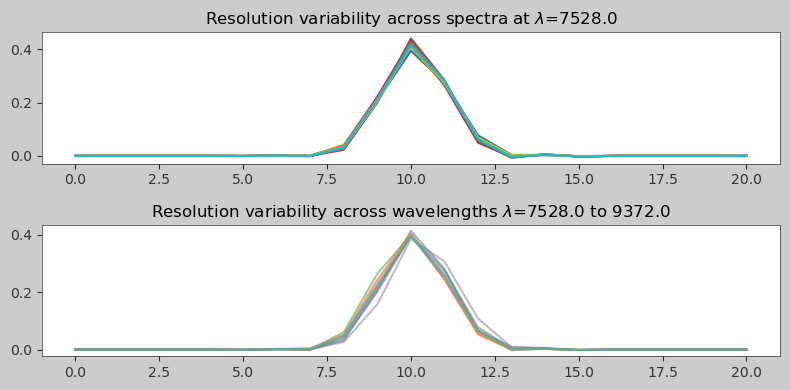

In [21]:
plt.figure(figsize=(8,4))

camera = 'z'
wave = spectra.wave[camera]

plt.subplot(211)
for j in np.linspace(0, spectra.num_spectra()-1, 10, dtype=int):
    Rj_dense = spectra.R[camera][j].toarray()
    x = Rj_dense[10, 0:21]
    plt.plot(x)

plt.title(f"Resolution variability across spectra at $\\lambda$={wave[10]:.1f}")

plt.subplot(212)
for k in np.linspace(10, num_wavelengths-11, 10, dtype=int):
    x = Rj_dense[k, k-10:k+11]
    plt.plot(x, alpha=0.5)

plt.title(f"Resolution variability across wavelengths $\\lambda$={wave[10]:.1f} to {wave[num_wavelengths-11]:.1f}")

plt.tight_layout()

We can see that the resolution varies both with spectrum number (top) and with wavelength (bottom), and can be non-symmetric
(another reason for parameterizing it as a matrix rather than a Gaussian sigma or FWHM).

## Gotchas

### Non-symmetric resolution and outliers

In the above plot, there is an outlier that is dramatically non-symmetric and different from the others.
This isn't because the DESI *hardware* has an oddly different resolution at a particular wavelength,
but rather because the spectroperfectionism algorithm calculates the *effective resolution* of the
extracted flux, given the noise and masking of the input data.  When a particular wavelength for a
fiber borders a large masked region of the CCD (e.g. due to a large cosmic ray or CCD defect),
then the effective resolution can be considerably different than it otherwise normally would be.

This again emphasizes why the resolution is parameterized per-spectrum, per-wavelength non-Gaussian matrix model
rather than a generic instrument resolution model that applies to everything or a simplified sigma or FWHM parameterization.

### Flux non-conservation

A bigger gotcha is that the resolution model from the spectroperfectionism extraction isn't really a convolution
in the sense that it is non-flux conserving at specific wavelengths.  We can see this by plotting the Resolution-"convolved"
spectrum of a constant flux=1 input:

In [22]:
ispec = 0
R = spectra.R['r'][ispec]
wave = spectra.wave['r']
nwave = R.shape[0]
flat_spectrum = np.ones(nwave)
convolved_spectrum = R.dot(flat_spectrum)

Text(0, 0.5, 'Resolution * constant_flux spectrum')

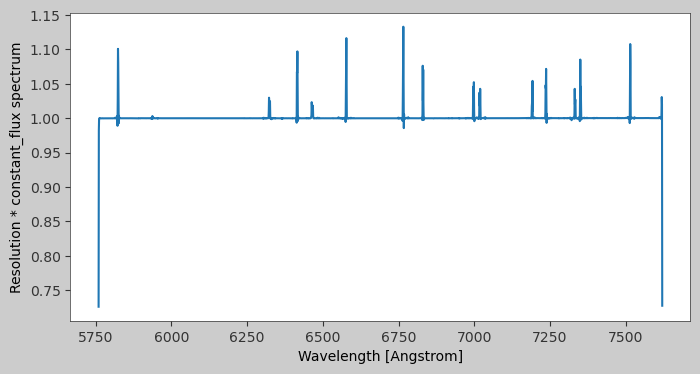

In [23]:
plt.figure(figsize=(8,4))
plt.plot(wave, convolved_spectrum)
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Resolution * constant_flux spectrum')

This non-conservation is for 2 reasons:
* At the edges, the convolution can push flux "off the edge" of the wavelength range, but it can't symmetrically convolve unobserved flux back into the observed wavelength range.
  * **Recommendation**: discard the first and last ~3 wavelengths of each camera.  These also have very low weight in their ivar due to the low throughput of the cameras at the endges, i.e. in a weighted analysis these pixels don't carry much weight anyway.
* Away from the edges, the effective resolution can be non-flux conserving for reasons similar to the asymmetry -- input pixels from noisy/masked CCD regions contribute differently to the resolution than low-noise regions. As a side-effect, model flux that would have projected into the noisy region also propagates differently, analogous to a weighted mean being different than `sum(samples)/len(samples)`.
  * **Recommendation**: compare `Resolution.dot(model)` to the `flux`, since this non-flux conservation is actually reflected in the flux itself, and fitting directly to the flux can lead to a biased answer.

## Summary

* The **Resolution Matrix** for each spectrum models the effective instrument resolution of the extracted flux.
* It is stored as a band-diagonal matrix to be multiplied by a perfect resolution model, to get the as-observed resolution model to compare to the data when doing fits.
* The underlying format on disk is designed to work with the `scipy.sparse.dia_matrix` class, though `desispec.resolution.Resolution` and `desispec.io.read_spectra` provide convenience wrappers around this.
* It is *not* parameterized as a Gaussian sigma or FWHM because it has non-Gaussian tails and can be asymmetric.
* The effective resolution varies with both with spectrum (per fiber per exposure), and with wavelength
* The biggest gotcha is that the model is not flux conserving, though comparing `Resolution.dot(model)` to `flux` is self consistent in mitigating this effect.